# Task 1

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.fftpack import fft

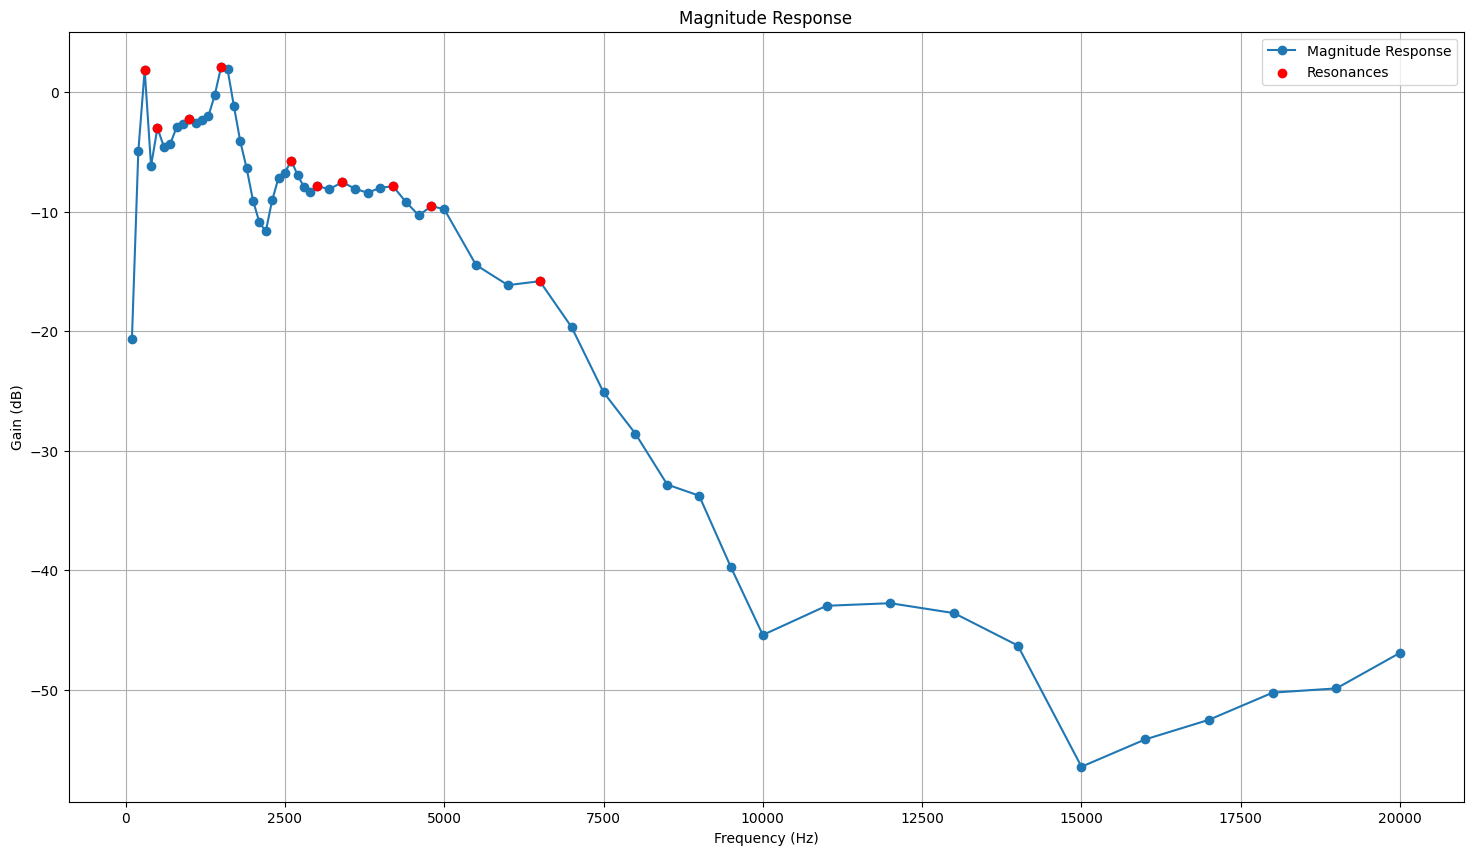

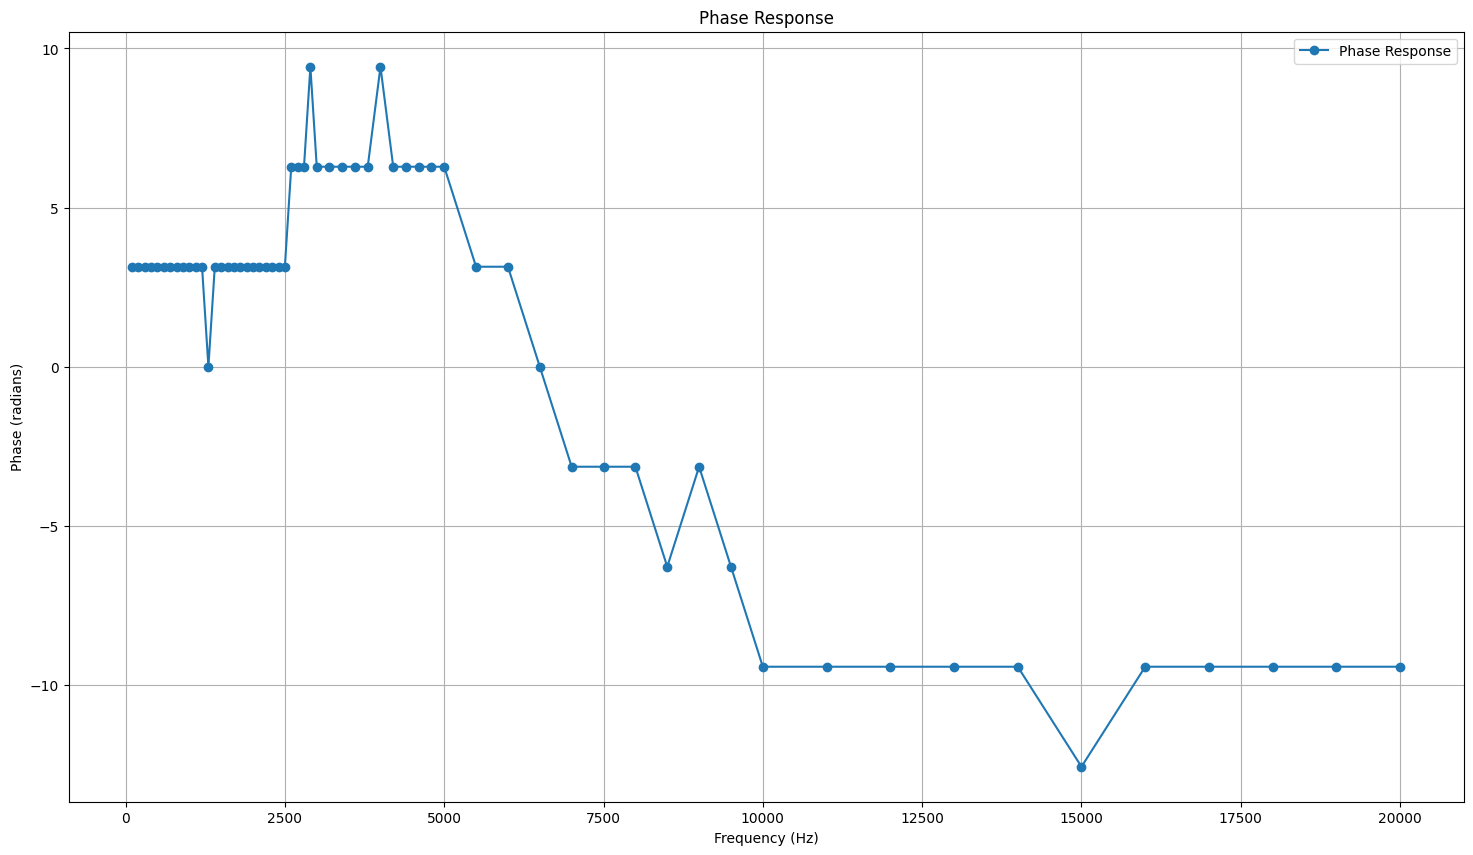

Resonant Frequencies and Quality Factors:
Resonant Frequency: 300 Hz, Q-Factor: 2.5986830705250394
Resonant Frequency: 500 Hz, Q-Factor: 0.34411784952158053
Resonant Frequency: 1000 Hz, Q-Factor: 0.7136534947464597
Resonant Frequency: 1500 Hz, Q-Factor: 4.651963521310255
Resonant Frequency: 2600 Hz, Q-Factor: 1.2781520125087278
Resonant Frequency: 3000 Hz, Q-Factor: 1.0309413002082919
Resonant Frequency: 3400 Hz, Q-Factor: 1.1895550174269678
Resonant Frequency: 4200 Hz, Q-Factor: 1.4433178202916088
Resonant Frequency: 4800 Hz, Q-Factor: 0.9296753621616176
Resonant Frequency: 6500 Hz, Q-Factor: 0.9543186417182347


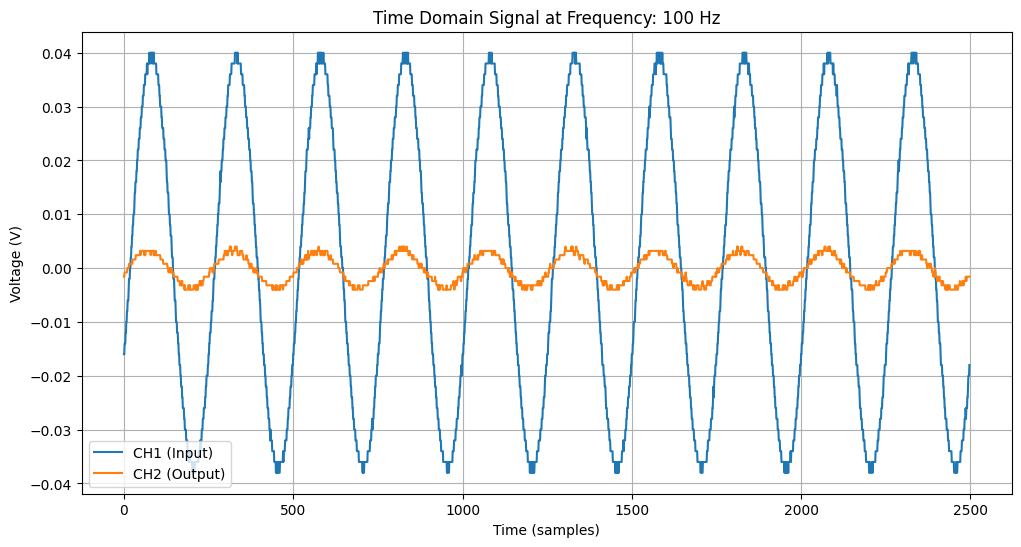

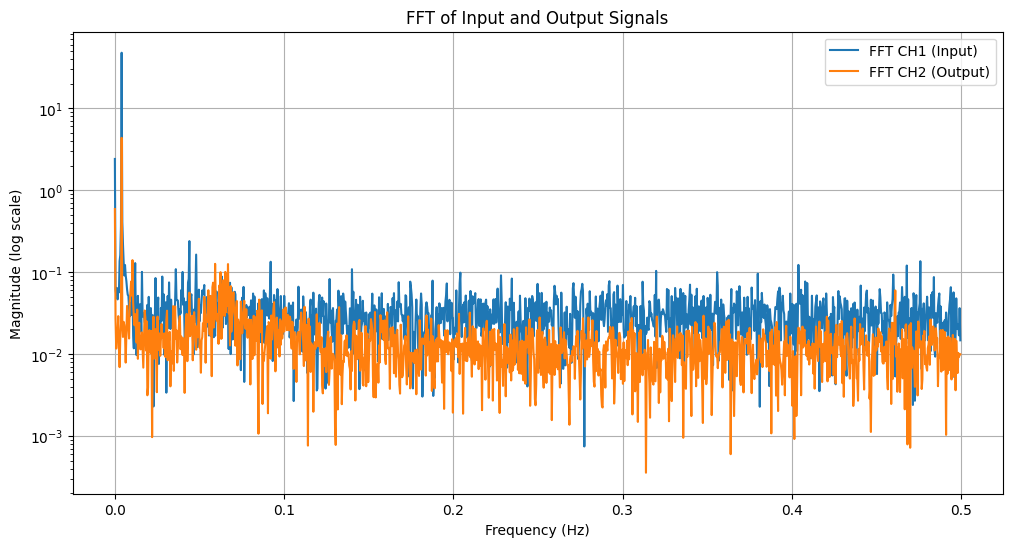

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.fftpack import fft
from scipy.interpolate import interp1d

base_dir = "./task1" 
gain_data = []
phase_data = []
time_data_ch1 = None
time_data_ch2 = None
selected_resonance = None

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        try:
            freq = int(folder.split('-')[-1][:-2])  
        except ValueError:
            continue  
        ch1_file = None
        ch2_file = None
        for file in os.listdir(folder_path):
            if "CH1" in file:
                ch1_file = os.path.join(folder_path, file)
            elif "CH2" in file:
                ch2_file = os.path.join(folder_path, file)
        
        if ch1_file and ch2_file:
            df_ch1 = pd.read_csv(ch1_file, skiprows=2, header=None)
            df_ch2 = pd.read_csv(ch2_file, skiprows=2, header=None)
            ch1_voltage = df_ch1.iloc[:, -2].dropna().astype(float).to_numpy()
            ch2_voltage = df_ch2.iloc[:, -2].dropna().astype(float).to_numpy()
            v_rms_ch1 = np.sqrt(np.mean(ch1_voltage ** 2))
            v_rms_ch2 = np.sqrt(np.mean(ch2_voltage ** 2))
            gain = v_rms_ch2 / v_rms_ch1 if v_rms_ch1 != 0 else np.nan
            gain_db = 20 * np.log10(gain) if gain > 0 else np.nan
            gain_data.append((freq, gain_db))
            phase_diff = np.angle(np.fft.fft(ch2_voltage)[0]) - np.angle(np.fft.fft(ch1_voltage)[0])
            phase_data.append((freq, phase_diff))
            
            if selected_resonance is None or gain_db > max([g[1] for g in gain_data]):
                selected_resonance = freq
                time_data_ch1 = ch1_voltage
                time_data_ch2 = ch2_voltage

gain_data.sort()
phase_data.sort()
updatedPhase = []
frequencies, gains_db = zip(*gain_data)
_, phases = zip(*phase_data)
updatedPhase = [(i - 2*np.pi) if i > np.pi else (i + 2*np.pi) if i < -np.pi else i for i in phases]
unwrapped_phase = np.unwrap(updatedPhase)
peaks, _ = find_peaks(gains_db, height=np.mean(gains_db))
resonant_freqs = [frequencies[i] for i in peaks]
interp_func = interp1d(frequencies, gains_db, kind='cubic', fill_value="extrapolate")
interp_frequencies = np.linspace(min(frequencies), max(frequencies), 5000)  # Increase density
interp_gains = interp_func(interp_frequencies)
q_factors = []
for peak in peaks:
    f_r = frequencies[peak]
    peak_mag = gains_db[peak]
    half_power = peak_mag - 3 
    left_candidates = [f for f in interp_frequencies if f < f_r and interp_func(f) <= half_power]
    right_candidates = [f for f in interp_frequencies if f > f_r and interp_func(f) <= half_power]
    
    if left_candidates and right_candidates:
        left_f = max(left_candidates)
        right_f = min(right_candidates)
        delta_f = right_f - left_f
        q_factor = f_r / delta_f
        q_factors.append((f_r, q_factor))
    else:
        q_factors.append((f_r, np.nan))
        print(f"Warning: Unable to calculate Q-factor for {f_r} Hz. Bandwidth estimation failed.")

plt.figure(figsize=(18, 10))
plt.plot(frequencies, gains_db, marker='o', linestyle='-', label='Magnitude Response')
plt.scatter(resonant_freqs, [gains_db[i] for i in peaks], color='red', label='Resonances', zorder=3) 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.title("Magnitude Response")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(frequencies, (-1)*unwrapped_phase, marker='o', linestyle='-', label='Phase Response')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.title("Phase Response")
plt.legend()
plt.grid()
plt.show()

print("Resonant Frequencies and Quality Factors:")
for f_r, q in q_factors:
    print(f"Resonant Frequency: {f_r} Hz, Q-Factor: {q if not np.isnan(q) else 'Calculation Failed'}")

if time_data_ch1 is not None and time_data_ch2 is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(time_data_ch1, label='CH1 (Input)')
    plt.plot(time_data_ch2, label='CH2 (Output)')
    plt.xlabel("Time (samples)")
    plt.ylabel("Voltage (V)")
    plt.title(f"Time Domain Signal at Frequency: {selected_resonance} Hz")
    plt.legend()
    plt.grid()
    plt.show()
    
    N = len(time_data_ch1)
    fft_ch1 = np.abs(fft(time_data_ch1))[:N // 2]
    fft_ch2 = np.abs(fft(time_data_ch2))[:N // 2]
    freqs = np.fft.fftfreq(N, d=1)[:N // 2]
    
    plt.figure(figsize=(12, 6))
    plt.semilogy(freqs, fft_ch1, label='FFT CH1 (Input)')
    plt.semilogy(freqs, fft_ch2, label='FFT CH2 (Output)')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (log scale)")
    plt.title("FFT of Input and Output Signals")
    plt.legend()
    plt.grid()
    plt.show()


# Task 2

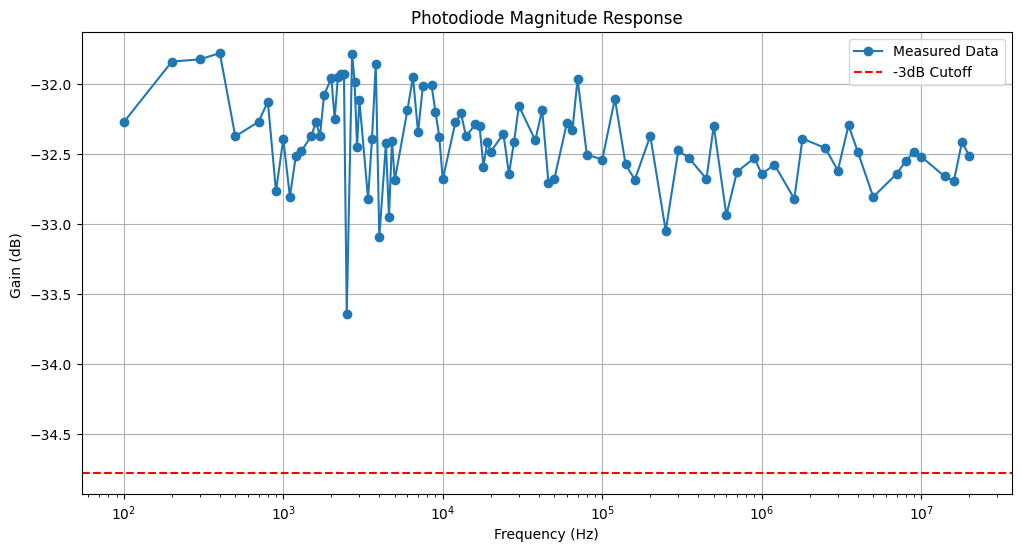

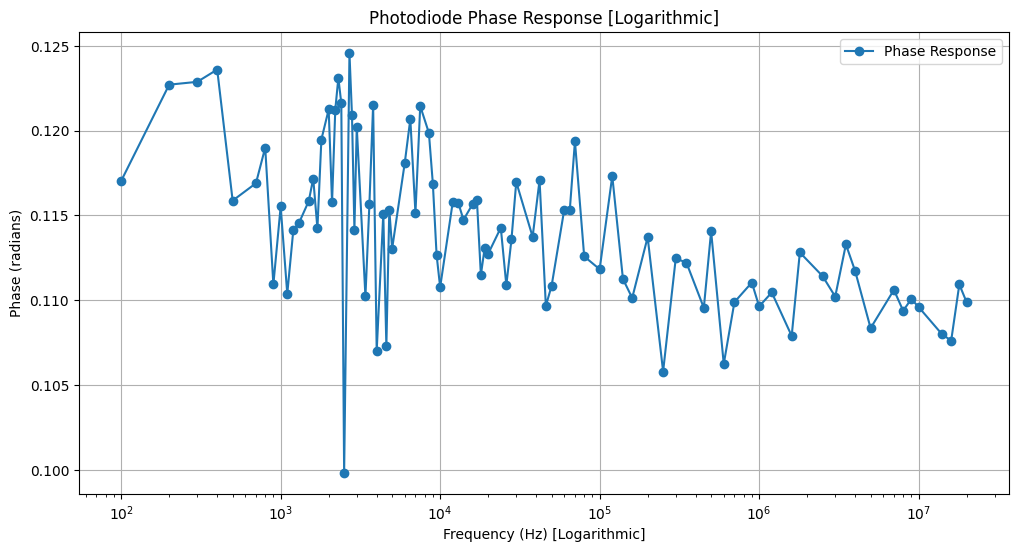

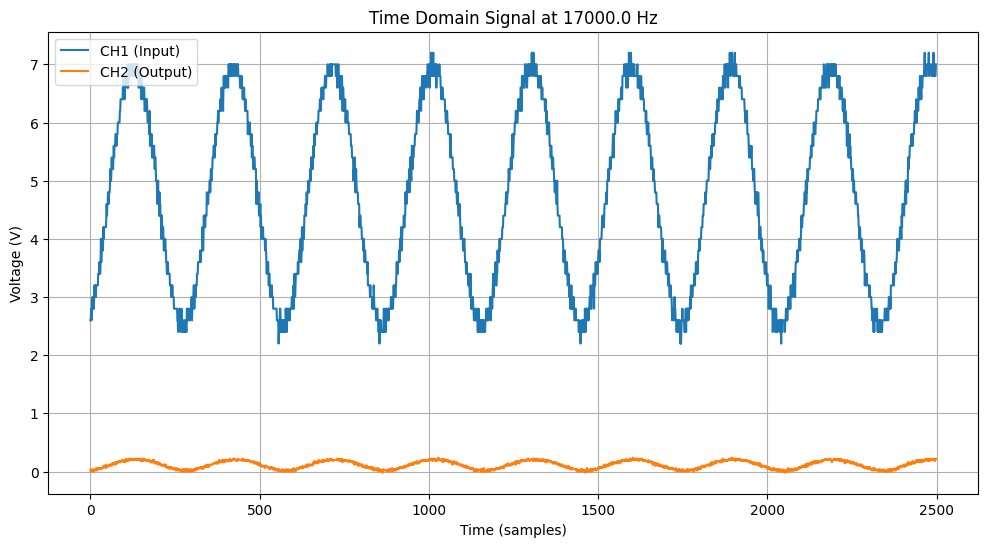

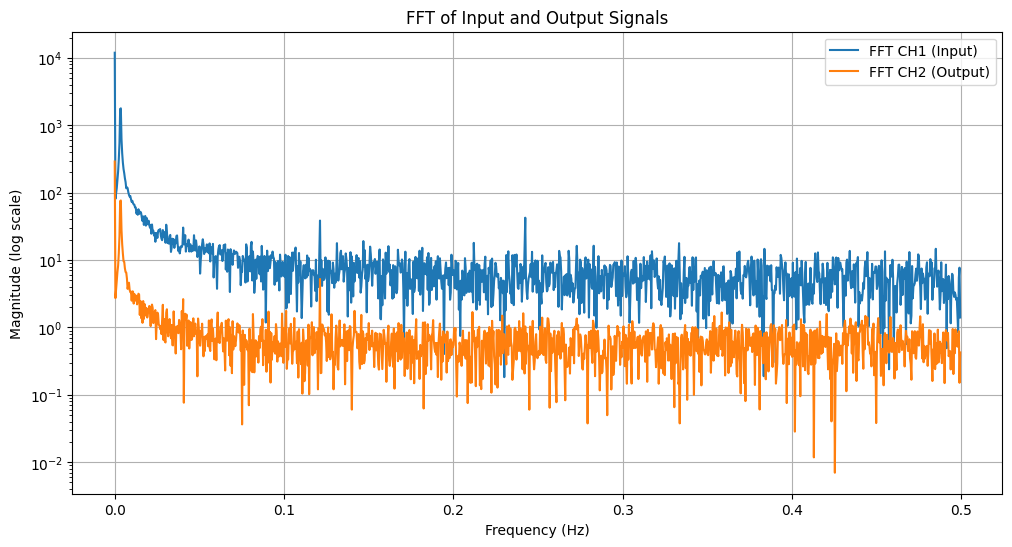

In [8]:
data_dir = "./task2" 
frequencies = []
gains_db = []
phases = []
time_data_ch1 = None
time_data_ch2 = None
selected_frequency = None
for folder in sorted(os.listdir(data_dir)):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        try:
            freq = float(''.join(filter(str.isdigit, folder.split('-')[-1])))  
        except ValueError:
            continue 
        ch1_file, ch2_file = None, None
        for file in os.listdir(folder_path):
            if "CH1" in file:
                ch1_file = os.path.join(folder_path, file)
            elif "CH2" in file:
                ch2_file = os.path.join(folder_path, file)

        if ch1_file and ch2_file:
            ch1_data = pd.read_csv(ch1_file)
            ch2_data = pd.read_csv(ch2_file)
            ch1_voltage = ch1_data.iloc[:, -2].dropna().astype(float).to_numpy()
            ch2_voltage = ch2_data.iloc[:, -2].dropna().astype(float).to_numpy()
            v_in = ch1_voltage.mean()
            v_out = ch2_voltage.mean()
            phase = ch2_voltage.mean()  
            if v_in > 0:
                gain_db = 20 * np.log10(np.abs(v_out / v_in))
                gains_db.append(gain_db)
                frequencies.append(freq)
                phases.append(phase)

                if selected_frequency is None or gain_db > max(gains_db):
                    selected_frequency = freq
                    time_data_ch1 = ch1_voltage
                    time_data_ch2 = ch2_voltage

num_points = int(0.8 * len(frequencies))  
indices = np.linspace(0, len(frequencies) - 1, num_points, dtype=int)

frequencies = np.array(frequencies)
gains_db = np.array(gains_db)
phases = np.array(phases)
frequencies = frequencies[indices]
gains_db = gains_db[indices]
phases = phases[indices]

sorted_indices = np.argsort(frequencies)
frequencies = frequencies[sorted_indices]
gains_db = gains_db[sorted_indices]
phases = phases[sorted_indices]
phases = np.unwrap(phases)

max_gain = np.max(gains_db)
cutoff_level = max_gain - 3


cutoff_idx = np.where(gains_db <= cutoff_level)[0]
cutoff_freq = frequencies[cutoff_idx[0]] if len(cutoff_idx) > 0 else None


plt.figure(figsize=(12, 6))
plt.plot(frequencies, gains_db, 'o-', label='Measured Data')
plt.axhline(y=cutoff_level, color='r', linestyle='--', label='-3dB Cutoff')
if cutoff_freq:
    plt.axvline(x=cutoff_freq, color='g', linestyle='--', label=f'Cutoff: {cutoff_freq:.2f} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB) ")
plt.title("Photodiode Magnitude Response")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(frequencies, phases, 'o-', label='Phase Response')
plt.xlabel("Frequency (Hz) [Logarithmic]")
plt.ylabel("Phase (radians)")
plt.title("Photodiode Phase Response [Logarithmic]")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

if cutoff_freq:
    print(f"3dB Cut-off Frequency: {cutoff_freq:.2f} Hz")


if time_data_ch1 is not None and time_data_ch2 is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(time_data_ch1, label='CH1 (Input)')
    plt.plot(time_data_ch2, label='CH2 (Output)')
    plt.xlabel("Time (samples)")
    plt.ylabel("Voltage (V)")
    plt.title(f"Time Domain Signal at {selected_frequency} Hz")
    plt.legend()
    plt.grid()
    plt.show()


    N = len(time_data_ch1)
    fft_ch1 = np.abs(fft(time_data_ch1))[:N // 2]
    fft_ch2 = np.abs(fft(time_data_ch2))[:N // 2]
    freqs = np.fft.fftfreq(N, d=1)[:N // 2]
    
    
    plt.figure(figsize=(12, 6))
    plt.semilogy(freqs, fft_ch1, label='FFT CH1 (Input)')
    plt.semilogy(freqs, fft_ch2, label='FFT CH2 (Output)')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (log scale)")
    plt.title("FFT of Input and Output Signals")
    plt.legend()
    plt.grid()
    plt.show()
